<a href="https://colab.research.google.com/github/itissandeep98/ML-Assignments/blob/master/Assignment3/ML_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports 

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
import random
from PIL import Image
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

# Pre Processing

In [82]:
class MyPreProcessor():
  """
  My steps for pre-processing for the All datasets.
  """

  def __init__(self):
    pass

  def pre_process(self, dataset):
    """
    Reading the file and preprocessing the input and output.
    Note that you will encode any string value and/or remove empty entries in this function only.
    Further any pre processing steps have to be performed in this function too. 

    Parameters
    ----------

    dataset : integer with acceptable values 0, 1, or 2
    0 ->  Dataset
    1 ->  Dataset
    2 ->  Dataset

    Returns
    -------
    X : 2-dimensional numpy array of shape (n_samples, n_features)
    y : 1-dimensional numpy array of shape (n_samples,)
    """
    scaler = StandardScaler()
    if dataset == 0:
      df=pd.read_csv("/content/sample_data/mnist_train_small.csv",header=None)
      X=df.iloc[:,1:].to_numpy()
      # X=scaler.fit_transform(X) 

      y=df[0].to_numpy()
      b = np.zeros((y.size, y.max()+1))
      b[np.arange(y.size),y] = 1
      y=b
           
    
    elif dataset == 1:
      df=pd.read_csv("/content/drive/MyDrive/ML_Assignment3/largeTrain.csv",header=None)
      X=df.iloc[:,1:].to_numpy()
      y=df[0].to_numpy()

    elif dataset == 2:
      df=pd.read_csv("/content/drive/MyDrive/ML_Assignment3/largeValidation.csv",header=None)
      X=df.iloc[:,1:].to_numpy()
      y=df[0].to_numpy()
    
    elif dataset == 3:
      df= pickle.load(open("/content/drive/MyDrive/ML_Assignment3/train_CIFAR.pickle","rb"))
      X=df['X']
      y=df['Y']
    elif dataset == 4:
      df= pickle.load(open("/content/drive/MyDrive/ML_Assignment3/test_CIFAR.pickle","rb"))
      X=df['X']
      y=df['Y']
    return X, y

preprocessor = MyPreProcessor()


#My Neural Network

In [102]:
class MyNeuralNetwork():
    """
    My implementation of a Neural Network Classifier.
    """

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh']
    weight_inits = ['zero', 'random', 'normal']

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        """
        Initializing a new MyNeuralNetwork object

        Parameters
        ----------
        n_layers : int value specifying the number of layers

        layer_sizes : integer array of size n_layers specifying the number of nodes in each layer

        activation : string specifying the activation function to be used
                     possible inputs: relu, sigmoid, linear, tanh

        learning_rate : float value specifying the learning rate to be used

        weight_init : string specifying the weight initialization function to be used
                      possible inputs: zero, random, normal

        batch_size : int value specifying the batch size to be used

        num_epochs : int value specifying the number of epochs to be used
        """

        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')

        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
        
        np.random.seed(10)
        self.n_layers=n_layers
        self.layer_sizes=layer_sizes 
        self.activation=activation 
        self.learning_rate=learning_rate 
        self.weight_init=weight_init
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        weights=[]
        bias=[]
        for i in range(self.n_layers-1):
          weights.append(np.array(self.weight_func((self.layer_sizes[i],self.layer_sizes[i+1]))))
          bias.append(np.zeros(self.layer_sizes[i+1])) 

        self.weights=np.array(weights)
        self.bias=np.array(bias)
        

    def activation_func(self,X):
      if self.activation=="relu":
        return self.relu(X),self.relu_grad(X)
      elif self.activation=="sigmoid":
        return self.sigmoid(X),self.sigmoid_grad(X)
      elif self.activation=="linear":
        return self.linear(X),self.linear_grad(X)
      elif self.activation=="tanh":
        return self.tanh(X),self.tanh_grad(X)
      else:
        return self.softmax(X),self.softmax_grad(X)

    def relu(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc=np.maximum(0,X)
        return x_calc

    def relu_grad(self, X):
        """
        Calculating the gradient of ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # print(X)
        x_calc=np.zeros(X.shape)
        x_calc[X>0]=1

        return x_calc

    def sigmoid(self, X):
        """
        Calculating the Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc= 1/(1+np.exp(-X))

        return x_calc

    def sigmoid_grad(self, X):
        """
        Calculating the gradient of Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        sig=self.sigmoid(X)
        x_calc=sig*(1-sig)
        return x_calc

    def linear(self, X):
        """
        Calculating the Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc=X
        return x_calc

    def linear_grad(self, X):
        """
        Calculating the gradient of Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc=np.zeros(X.shape)
        x_calc[X>0]=1
        x_calc[X<0]=-1
        return x_calc

    def tanh(self, X):
        """
        Calculating the Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc=np.tanh(X)
        return x_calc

    def tanh_grad(self, X):
        """
        Calculating the gradient of Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        tanh=self.tanh(X)
        x_calc=1-tanh**2
        return x_calc

    def softmax(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # expo = np.exp(X)
        expo = np.exp(X - X.max())
        x_calc=expo/expo.sum(axis=0)
        return x_calc
    

    def weight_func(self,shape):
      if self.weight_init=="zero":
        return self.zero_init(shape)
      elif self.weight_init=="random":
        return self.random_init(shape)
      else:
        return self.normal_init(shape)

    def zero_init(self, shape):
        """
        Calculating the initial weights after Zero Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        weight= np.zeros(shape)
        return weight 

    def random_init(self, shape):
        """
        Calculating the initial weights after Random Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        weight= np.random.randn(shape[0],shape[1])*0.01
        return weight 

    def normal_init(self, shape):
        """
        Calculating the initial weights after Normal(0,1) Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        weight=np.random.normal(size=shape)
        return weight
    
    def cross_entropy(self,y_hat,y):
        samples=y.shape[0]
        error=y_hat-y
        return error/samples


    def fit(self, X, y):
        """
        Fitting (training) the linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.
        
        Returns
        -------
        self : an instance of self
        """
        

        weights=self.weights
        bias=self.bias

        for epoch in range(self.num_epochs):
          for batch in range(0,X.shape[0],self.batch_size):
            X_sample=X[batch:batch+self.batch_size,:]
            y_sample=y[batch:batch+self.batch_size]
            input=X_sample
            output=y_sample
            preActivation_H = {}
            postActivation_H = {}

            # Forward Propagation
            for layer in range(self.n_layers-1):
              layer_weight=weights[layer]
              hidden_output=input.dot(layer_weight)+bias[layer]
              hidden_output_activate,_=self.activation_func(hidden_output)          
              input=hidden_output_activate  
              preActivation_H[layer]=hidden_output     
              postActivation_H[layer]=hidden_output_activate

            
            # Backward Propagation
            aw=self.softmax(preActivation_H[self.n_layers-2])
            dW=self.cross_entropy(aw ,output)
            prev_weights= deepcopy(weights)
            weights[self.n_layers-2]-=self.learning_rate*(postActivation_H[self.n_layers-3].T.dot(dW))
            bias[self.n_layers-2]-=self.learning_rate*np.sum(dW,axis=0)

            for layer in range(self.n_layers-3,0,-1):
              delta=dW.dot(prev_weights[layer+1].T)
              _,derv=self.activation_func(preActivation_H[layer])
              dW=delta*derv

              weights[layer]-=self.learning_rate*postActivation_H[layer-1].T.dot(dW)
              bias[layer]-=self.learning_rate*np.sum(dW,axis=0)

            delta=dW.dot(prev_weights[1].T)
            _,derv=self.activation_func(preActivation_H[0])
            dW=delta*derv
            weights[0]-=self.learning_rate*X_sample.T.dot(dW)
            bias[0]-=self.learning_rate*np.sum(dW,axis=0)

        self.weights=weights
        self.bias=bias
        return self

    def predict_proba(self, X):
        """
        Predicting probabilities using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the 
            class wise prediction probabilities.
        """
        y=X
        for w, b in zip(self.weights, self.bias):
            z = np.dot(y,w) + b
            y,_ = self.activation_func(z)

        # return the numpy array y which contains the probability of predicted values
        return y

    def predict(self, X):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
        """
        y=self.predict_proba(X)

        # return the numpy array y which contains the predicted values
        return y.argmax(axis=1)

    def score(self, X, y):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as testing labels.

        Returns
        -------
        acc : float value specifying the accuracy of the model on the provided testing set
        """

        y_pred=self.predict(X)
        y=y.argmax(axis=1)
        acc=metrics.accuracy_score(y,y_pred)
        return acc

## Testing

In [103]:
scaler = StandardScaler()
X, y = preprocessor.pre_process(0)
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

(20000, 784) (20000, 10)


In [104]:
classifier=MyNeuralNetwork(5,[784,256, 128, 64,10],'sigmoid',0.1,'random',1024,100)
classifier.fit(X_train,y_train)
# print(classifier.weights)
classifier.score(X_test,y_test)

0.098

In [21]:
classifier.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
np.random.randn(2,5)*0.01

array([[ 0.0067381 , -0.01307217,  0.00018689, -0.00018207, -0.01995399],
       [ 0.0057561 , -0.00519099, -0.01337942,  0.02140737,  0.00269379]])

# Q3

In [65]:
X_train,y_train= preprocessor.pre_process(1)
X_val,y_val= preprocessor.pre_process(2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((9000, 128), (9000,), (1000, 128), (1000,))

In [59]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLP,self).__init__()
    self.input_fc = nn.Linear(input_dim, hidden_dim)
    self.output_fc = nn.Linear(hidden_dim, output_dim)
        
  def forward(self, x):
    h_1 = F.relu(self.input_fc(x))
    y_pred = self.output_fc(h_1)
    return y_pred

In [60]:
class MyDataset(data.Dataset):

  def __init__(self,X,y):
    self.X=X
    self.y=y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,i):
    return self.X[i],self.y[i]

In [66]:
def train(model, train_iterator,val_iterator, optimizer, criterion, device,epochs,flag=True):  
    # model.train()
    ce_loss=[]
    val_loss=[]
    for epoch in range(epochs):
      epoch_loss = 0
      epoch_loss_val=0
      for train,valid in zip(train_iterator,val_iterator):
          # training
          x,y = train
          x = x.to(device)
          y = y.to(device)

          optimizer.zero_grad()
          y_pred = model(x.float())
          loss = criterion(y_pred, y)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()

          #validation
          x_val,y_val = valid
          x_val = x_val.to(device)
          y_val = y_val.to(device)          
          y_val_pred= model(x_val.float())
          loss= criterion(y_val_pred, y_val)
          epoch_loss_val += loss.item()
      
      ce_loss.append(epoch_loss/ len(train_iterator))
      val_loss.append(epoch_loss_val/ len(val_iterator))

      if((epoch+1)%100==0):
        print("epoch:",epoch+1,"\t",epoch_loss/ len(train_iterator),epoch_loss_val/ len(val_iterator) )
    if(not flag):
      return ce_loss,val_loss
    return np.mean(ce_loss),np.mean(val_loss)

## 1)

### a)

5
epoch: 100 	 1.429646372795105 1.6679607033729553
epoch: 200 	 1.4174147579405043 1.6660494953393936
epoch: 300 	 1.4150738451215956 1.6673898994922638
epoch: 400 	 1.4121552573310003 1.6675715446472168
epoch: 500 	 1.4089178244272869 1.6667692512273788
20
epoch: 100 	 1.3705570035510592 1.6330607235431671
epoch: 200 	 1.3636595010757446 1.628951445221901
epoch: 300 	 1.362018346786499 1.6337948590517044
epoch: 400 	 1.3601501252916124 1.6344797909259796
epoch: 500 	 1.3613705502616034 1.6317482143640518
50
epoch: 100 	 1.3620342546039157 1.624546393752098
epoch: 200 	 1.355633060137431 1.6195921003818512
epoch: 300 	 1.352986733118693 1.6183650642633438
epoch: 400 	 1.351118220223321 1.6090140342712402
epoch: 500 	 1.3488270309236314 1.6121167540550232
100
epoch: 100 	 1.3553993966844347 1.6147668212652206
epoch: 200 	 1.3521797789467707 1.6143093705177307
epoch: 300 	 1.3456170558929443 1.603479728102684
epoch: 400 	 1.3433796299828424 1.596004694700241
epoch: 500 	 1.3417748212814

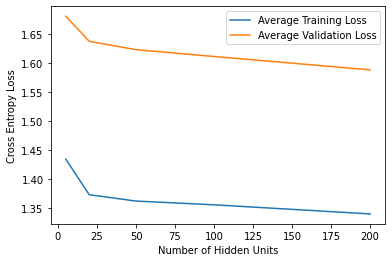

In [68]:
hidden_units=[5, 20, 50, 100 ,200]
input_size=128
output_size=10

ce_loss=[]
val_loss=[]

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

train_data=MyDataset(X_train,y_train)
val_data=MyDataset(X_val,y_val)

for h_unit in hidden_units:
  print(h_unit)
  train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = 1024)
  val_iterator = data.DataLoader(val_data, batch_size = 126)
  model = nn.Sequential(nn.Linear(input_size, h_unit),
                        nn.ReLU(),
                        nn.Linear(h_unit, output_size),
                        nn.Softmax(dim=1))
  # model=MLP(input_size,output_size,h_unit)
  optimizer = optim.Adam(model.parameters(),lr=0.01)

  t_loss,v_loss=train(model,
                      train_iterator,
                      val_iterator,
                      optimizer,
                      criterion,
                      device,
                      500)
  ce_loss.append(t_loss)
  val_loss.append(v_loss)

plt.plot(hidden_units,ce_loss,label="Average Training Loss")
plt.plot(hidden_units,val_loss,label="Average Validation Loss")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Number of Hidden Units")
plt.legend()

## 2)

### a)

0.1
epoch: 100 	 1.462270286348131 2.2195672690868378


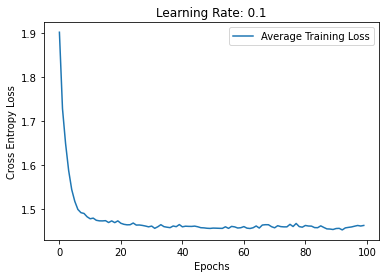

0.01
epoch: 100 	 1.4352003203497992 2.192150294780731


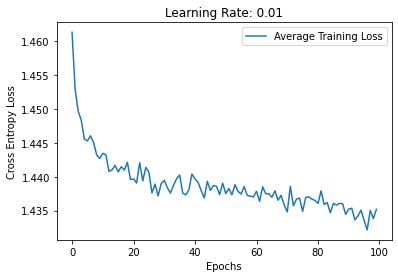

0.001
epoch: 100 	 1.4336902035607233 2.1906075477600098


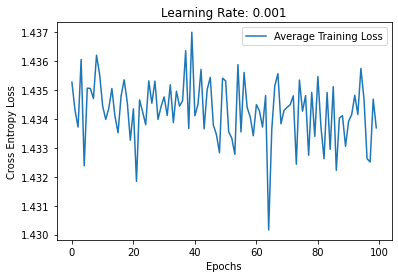

In [274]:
learning_rates=[0.1, 0.01, 0.001]
input_size=128
hidden_size=4
output_size=10

criterion = nn.CrossEntropyLoss()

train_data=MyDataset(X_train,y_train)
val_data=MyDataset(X_val,y_val)

train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = 1024)
val_iterator = data.DataLoader(val_data, shuffle = True, batch_size = 126)

model = nn.Sequential(nn.Linear(input_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, output_size),
                        nn.Softmax(dim=1))
for lr in learning_rates:
  print(lr)
  optimizer = optim.Adam(model.parameters(),lr=lr)
  t_loss,v_loss=train(model,
                      train_iterator,
                      val_iterator,
                      optimizer,
                      criterion,
                      device,
                      100,
                      False)
  
  plt.figure()
  plt.title("Learning Rate: "+str(lr))
  plt.plot(range(100),t_loss,label="Average Training Loss")
  # plt.plot(range(100),v_loss,label="Average Validation Loss")
  plt.ylabel("Cross Entropy Loss")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

# 4

In [69]:
X_train,y_train=preprocessor.pre_process(3)
X_test,y_test=preprocessor.pre_process(4)

X_train.shape,X_test.shape,y_train.shape

((10000, 3072), (2000, 3072), (10000,))

## 1) EDA

In [61]:
df=pd.DataFrame(X_train)
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

20
24


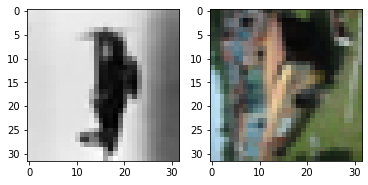

In [62]:
def unique_images():
  unique_label=[]
  for i in range(20,X_train.shape[0]):
    if(y_train[i] not in unique_label):
      plt.subplot(1,2,y_train[i]+1)
      data = X_train[i, :] 
      data = np.reshape(data, (32,32,3), order='F' ) 
      plt.imshow(data)
      print(i)
      unique_label.append(y_train[i])
unique_images()
      

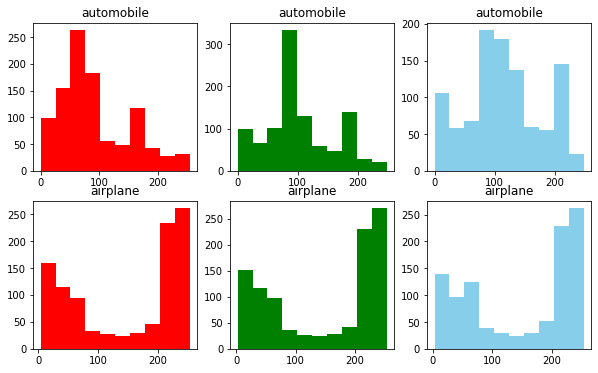

In [68]:
def display_color_hists(images, labels, indices, class_names=class_names):
    fig = plt.figure(figsize=(10,6))
    n = 0
    for i in indices:
        plt.subplot(2,3,n+1)
        plt.hist(images[i][:1024],color = "red")
        plt.title(class_names[labels[i]])
        n += 1
        
        plt.subplot(2,3,n+1)
        plt.hist(images[i][1024:2048],color = "green")
        plt.title(class_names[labels[i]])
        n += 1
        
        plt.subplot(2,3,n+1)
        plt.hist(images[i][2048:],color = "skyblue")
        plt.title(class_names[labels[i]])
        n += 1
    plt.show()
display_color_hists(X_train, y_train,[0,2] )

In [64]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([5000, 5000]))

## 2) AlexNet

In [74]:
class MyDataset1(data.Dataset): 
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform
        self.img_shape = data.shape
        
    def __getitem__(self, index): 
        img_reshaped = np.transpose(np.reshape(self.data[index],(3, 32,32)))
  
        img = Image.fromarray(img_reshaped)
        label = self.label[index]
        if self.transform is not None:
            img = self.transform(img)
            # img=torch.unsqueeze(img, 0)
        else:
            img_to_tensor = transforms.ToTensor()
            img = img_to_tensor(img)
        return img, label
        
    def __len__(self):
        return self.data.shape[0]

In [75]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [79]:
train_transform_aug = transforms.Compose([
    transforms.Resize((40, 40)),       
    transforms.ToTensor(),
    transforms.Pad(16),
    transforms.Normalize( mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
  )
train_data=MyDataset1(X_train,y_train,train_transform_aug)

train_loader = data.DataLoader(dataset=train_data,
                          batch_size=X_train.shape[0], 
                          shuffle=True)

len(train_loader)

1

In [80]:
for x,y in train_loader:
  output=alexnet(x)
  print(output.size())

torch.Size([10000, 1000])


In [81]:
output.size()

torch.Size([10000, 1000])